In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt


In [10]:
# Load the Cora dataset
dataset = Planetoid(root=".", name="Cora", transform=NormalizeFeatures())
data = dataset[0]  # Get the graph data


In [11]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [12]:
class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 16, heads=8, concat=True)  # Multi-head attention
        self.conv2 = GATConv(16 * 8, num_classes, heads=1, concat=False)  # Final layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)  # Exponential Linear Unit activation
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [13]:
# Instantiate Models
gcn_model = GCN(num_features=dataset.num_node_features, num_classes=dataset.num_classes)
gat_model = GAT(num_features=dataset.num_node_features, num_classes=dataset.num_classes)

# Optimizers
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)

# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()


In [14]:
# Training function for GCN
def train_gcn():
    gcn_model.train()
    gcn_optimizer.zero_grad()
    out = gcn_model(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    gcn_optimizer.step()
    return loss.item()

# Training function for GAT
def train_gat():
    gat_model.train()
    gat_optimizer.zero_grad()
    out = gat_model(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    gat_optimizer.step()
    return loss.item()


In [15]:
# Evaluation function for GCN
def test_gcn():
    gcn_model.eval()
    out = gcn_model(data)
    pred = out.argmax(dim=1)  # Get class predictions
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    accuracy = correct / data.test_mask.sum().item()
    return accuracy

# Evaluation function for GAT
def test_gat():
    gat_model.eval()
    out = gat_model(data)
    pred = out.argmax(dim=1)  # Get class predictions
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    accuracy = correct / data.test_mask.sum().item()
    return accuracy


In [16]:
# Training loop for both models
epochs = 200
gcn_losses, gat_losses = [], []
gcn_acc_list, gat_acc_list = [], []

for epoch in range(epochs):
    gcn_loss = train_gcn()
    gat_loss = train_gat()

    gcn_losses.append(gcn_loss)
    gat_losses.append(gat_loss)

    gcn_acc = test_gcn()
    gat_acc = test_gat()

    gcn_acc_list.append(gcn_acc)
    gat_acc_list.append(gat_acc)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: GCN Loss={gcn_loss:.4f}, GCN Acc={gcn_acc:.4f} | GAT Loss={gat_loss:.4f}, GAT Acc={gat_acc:.4f}")


Epoch 0: GCN Loss=1.9461, GCN Acc=0.0700 | GAT Loss=1.9461, GAT Acc=0.3110
Epoch 20: GCN Loss=1.6652, GCN Acc=0.6150 | GAT Loss=0.7071, GAT Acc=0.8110
Epoch 40: GCN Loss=1.2345, GCN Acc=0.6910 | GAT Loss=0.2315, GAT Acc=0.8000
Epoch 60: GCN Loss=0.8508, GCN Acc=0.7660 | GAT Loss=0.1483, GAT Acc=0.7700
Epoch 80: GCN Loss=0.6050, GCN Acc=0.7930 | GAT Loss=0.1112, GAT Acc=0.7630
Epoch 100: GCN Loss=0.4590, GCN Acc=0.8020 | GAT Loss=0.0902, GAT Acc=0.7530
Epoch 120: GCN Loss=0.3700, GCN Acc=0.8070 | GAT Loss=0.0768, GAT Acc=0.7430
Epoch 140: GCN Loss=0.3138, GCN Acc=0.8170 | GAT Loss=0.0681, GAT Acc=0.7180
Epoch 160: GCN Loss=0.2760, GCN Acc=0.8170 | GAT Loss=0.0636, GAT Acc=0.6920
Epoch 180: GCN Loss=0.2486, GCN Acc=0.8170 | GAT Loss=0.0607, GAT Acc=0.6830


In [17]:
# Save the trained models
torch.save(gcn_model.state_dict(), "gcn_cora.pth")
torch.save(gat_model.state_dict(), "gat_cora.pth")

# Final Accuracy
final_gcn_acc = test_gcn()
final_gat_acc = test_gat()
print(f"Final Test Accuracy - GCN: {final_gcn_acc:.4f}, GAT: {final_gat_acc:.4f}")


Final Test Accuracy - GCN: 0.8160, GAT: 0.6820


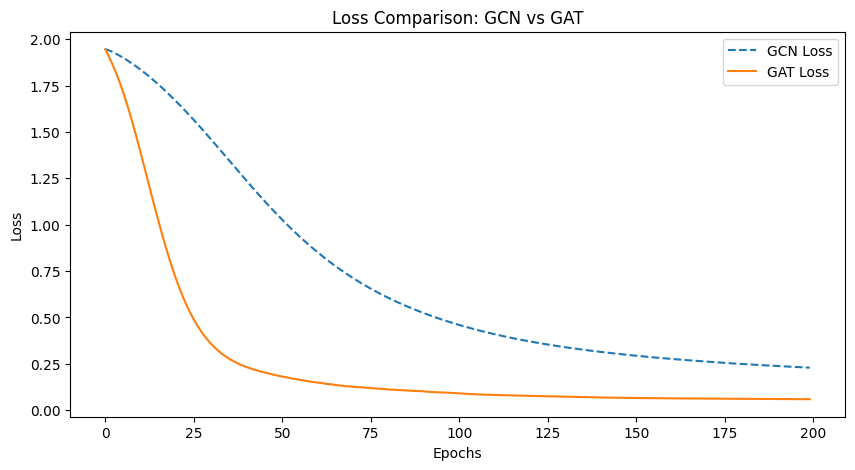

In [18]:
plt.figure(figsize=(10,5))
plt.plot(range(epochs), gcn_losses, label="GCN Loss", linestyle='dashed')
plt.plot(range(epochs), gat_losses, label="GAT Loss", linestyle='solid')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison: GCN vs GAT")
plt.legend()
plt.show()


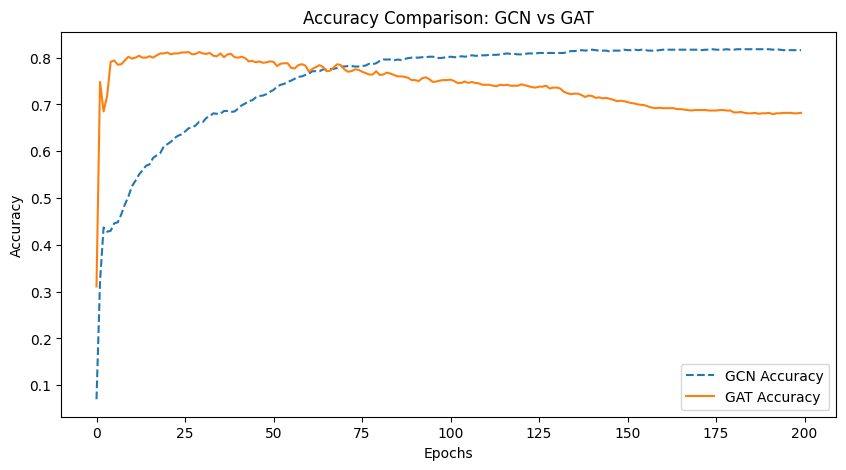

In [19]:
plt.figure(figsize=(10,5))
plt.plot(range(epochs), gcn_acc_list, label="GCN Accuracy", linestyle='dashed')
plt.plot(range(epochs), gat_acc_list, label="GAT Accuracy", linestyle='solid')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: GCN vs GAT")
plt.legend()
plt.show()


In [20]:
final_gcn_acc = test_gcn()
final_gat_acc = test_gat()

print(f"Final GCN Test Accuracy: {final_gcn_acc * 100:.2f}%")
print(f"Final GAT Test Accuracy: {final_gat_acc * 100:.2f}%")


Final GCN Test Accuracy: 81.60%
Final GAT Test Accuracy: 68.20%
